In [1]:
import os
path = os.getcwd()
path

'/home/dyna/Documents/sawada/debate_score'

In [2]:
# roberta_linear_test
## import module

import random
import numpy as np
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter
from keras.preprocessing import sequence
from matplotlib import pyplot as plt
import set_debates


Using TensorFlow backend.


In [3]:
# cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
## speech, score set

microchip_debate = "./topic/microchip/debates.txt"
microchip_order = "./topic/microchip/orders.txt"
microchip_score = "./topic/microchip/scores.txt"
part_job_debate = "./topic/part-time-job/debates.txt"
part_job_order = "./topic/part-time-job/orders.txt"
part_job_score = "./topic/part-time-job/scores.txt"
four_work_debate = "./topic/four-day-work/debates.txt"
four_work_order = "./topic/four-day-work/orders.txt"
four_work_score = "./topic/four-day-work/scores.txt"

# microchip_speech
Mdebate_lists = set_debates.set_speech_list(microchip_debate,microchip_order)
Mspeeches_list = set_debates.flatten(Mdebate_lists)
# microchip_score
with open(microchip_score, 'r') as h:
    scores = h.read()
    Mscore_list = [float(s) for s in scores.split()]

# part_job_speech
Pdebate_lists = set_debates.set_speech_list(part_job_debate,part_job_order)
Pspeeches_list = set_debates.flatten(Pdebate_lists)
# part_job_score
with open(part_job_score, 'r') as h:
    scores = h.read()
    Pscore_list = [float(s) for s in scores.split()]

# four-work_speech
Fdebate_lists = set_debates.set_speech_list(four_work_debate, four_work_order)
Fspeeches_list = set_debates.flatten(Fdebate_lists)
# four-work_score
with open(four_work_score, 'r') as h:
    scores = h.read()
    Fscore_list = [float(s) for s in scores.split()]
    
# check    
Mspeech_test = Mspeeches_list[:10]
Mspeech_train = Mspeeches_list[10:]
len(Mspeech_test)

10

In [5]:
## prepare inputs

def roberta_encode(speeches_list):
    # tokenizer
    tokenizer = RobertaTokenizer.from_pretrained("roberta-large")
    # token
    speech_tokens = list(
        map(
            lambda t: tokenizer.tokenize(t)[-511:], speeches_list
        )
    )
    # encode   -ids
    speech_ids = list(
        map(
            lambda t: tokenizer.encode(t, add_special_tokens=True), speech_tokens
        )
    )
    # 要素の大きさを512に　つめる

    speech_ids = sequence.pad_sequences(
        speech_ids, maxlen=512, truncating='post', padding='post', dtype='int'
    )

    return speech_ids


Mspeech_ids_train = roberta_encode(Mspeech_train)
Mspeech_ids_test = roberta_encode(Mspeech_test)
Pspeech_ids = roberta_encode(Pspeeches_list)
Fspeech_ids = roberta_encode(Fspeeches_list)


In [6]:
# embedding

def roberta_embedding(speech_ids):
    # to_tensor
    input_roberta = torch.tensor(speech_ids)
    # input_size
    input_roberta = input_roberta.to(device)
    roberta = RobertaModel.from_pretrained("roberta-large")
    roberta = roberta.to(device)
    with torch.no_grad():
        roberta_out = roberta(input_roberta)
    pooled_speech = roberta_out[1]
    return pooled_speech

Mpooled_speech_train = roberta_embedding(Mspeech_ids_train)
Ppooled_speech = roberta_embedding(Pspeech_ids)
Fpooled_speech = roberta_embedding(Fspeech_ids)
Mpooled_speech_test = roberta_embedding(Mspeech_ids_test)

In [ ]:
"""
import csv
with open('Fpooled_speech.csv', 'wt') as f:
    writer = csv.writer(f)
    writer.writerows(Fpooled_speech)


In [7]:
Mscore_test = Mscore_list[:10]
Mscore_train = Mscore_list[10:]
Mscore_test

[28.5, 24.2, 27.1, 20.0, 14.2, 8.57, -25.7, -5.71, -20.0, -15.7]

In [8]:
# label 確認
Mscore_train = torch.tensor(Mscore_train, device=device)
Pscore = torch.tensor(Pscore_list, device=device)
Fscore = torch.tensor(Fscore_list, device=device)
Mscore_test = torch.tensor(Mscore_test, device=device)

In [9]:
# dataset
class Mydataset(torch.utils.data.Dataset):
    def __init__(self, data, label):
        self.data = data
        self.data_num = len(data)
        self.label = label
        
    def __len__(self):
        return self.data_num
    
    def __getitem__(self, idx):
        out_data = self.data[idx]
        out_label = self.label[idx]
        return out_data, out_label

In [10]:
Mdata_set_train = Mydataset(Mpooled_speech_train, Mscore_train)
Pdata_set = Mydataset(Ppooled_speech, Pscore)
Fdata_set = Mydataset(Fpooled_speech, Fscore)
Mdata_set_test = Mydataset(Mpooled_speech_test, Mscore_test)

print("microchip:{}\tpart-job:{}\tfour-work:{}".format(len(Mdata_set_train)+len(Mdata_set_test), len(Pdata_set), len(Fdata_set)))

microchip:50	part-job:11	four-work:10


In [ ]:
# Mrand+P+F : Mrand
train_dataset = Mdata_set_train + Pdata_set + Fdata_set
test_dataset = Mdata_set_test

In [ ]:
# M+P : F
train_dataset = Mdata_set_train + Mdata_set_test + Pdata_set
test_dataset = Fdata_set

In [11]:
# M+F : P
train_dataset = Mdata_set_train + Fdata_set + Mdata_set_test
test_dataset = Pdata_set

In [12]:
# define_model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1024, 1)

    def forward(self, x):
        out = self.fc1(x)
        return out

In [25]:
# hyper params
num_epochs = 1000
learning_rate = 3e-7

model_cls = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(model_cls.parameters(), lr=learning_rate)
model_cls = model_cls.to(device)

In [34]:

# set\data\logger
loss_log = []
loss_v_log = []


for epoch in range(num_epochs):
    running_loss = 0.0
    running_v_loss = 0.0
    for i, data in enumerate(train_dataset):
        x_t, y_t = data
        optimizer.zero_grad()
        # forward pass
        outputs = model_cls(x_t)
        loss = criterion(outputs, y_t)
        
        # backward
        loss.backward()
        optimizer.step()
    
        running_loss += loss.item()
        
    loss_log.append(running_loss/len(train_dataset))
    
    with torch.no_grad():
        for j, data in enumerate(test_dataset):
            x_val, y_val = data
            outputs_val = model_cls(x_val)
            loss = criterion(outputs_val, y_val)
            running_v_loss += loss.item()
        loss_v_log.append(running_v_loss/len(test_dataset))
            
    if (epoch+1) % 10 == 0:
        print("Epoch:{}, Loss(train):{:.2f}, Loss(val):{:.2f}".format(epoch+1, running_loss/len(train_dataset), running_v_loss/len(test_dataset)))


    
print('----DONE----')

Epoch:10, Loss(train):460.44, Loss(val):404.87
Epoch:20, Loss(train):460.43, Loss(val):404.86
Epoch:30, Loss(train):460.42, Loss(val):404.86
Epoch:40, Loss(train):460.42, Loss(val):404.86
Epoch:50, Loss(train):460.41, Loss(val):404.85
Epoch:60, Loss(train):460.41, Loss(val):404.85
Epoch:70, Loss(train):460.40, Loss(val):404.85
Epoch:80, Loss(train):460.39, Loss(val):404.84
Epoch:90, Loss(train):460.39, Loss(val):404.84
Epoch:100, Loss(train):460.38, Loss(val):404.84
Epoch:110, Loss(train):460.38, Loss(val):404.83
Epoch:120, Loss(train):460.37, Loss(val):404.83
Epoch:130, Loss(train):460.37, Loss(val):404.83
Epoch:140, Loss(train):460.36, Loss(val):404.82
Epoch:150, Loss(train):460.35, Loss(val):404.82
Epoch:160, Loss(train):460.35, Loss(val):404.82
Epoch:170, Loss(train):460.34, Loss(val):404.82
Epoch:180, Loss(train):460.34, Loss(val):404.81
Epoch:190, Loss(train):460.33, Loss(val):404.81
Epoch:200, Loss(train):460.33, Loss(val):404.81
Epoch:210, Loss(train):460.32, Loss(val):404.80
E

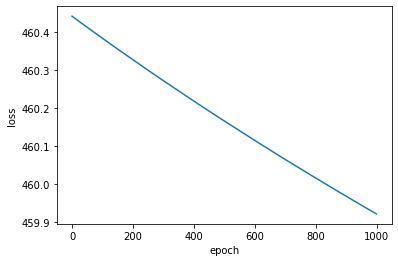

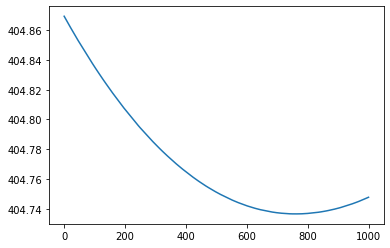

In [35]:
plt.plot(loss_log)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.plot(loss_v_log)

In [ ]:
# test
running_test_loss = 0.0
for i, data in enumerate(test_dataset):
    x_test, y_test = data
    with torch.no_grad():
        pred = model_cls(x_test)
        loss = criterion(pred, y_test)
        running_test_loss += loss.item()
        print("pred:{:.4f}\ty_test:{:.4f}".format(pred.item(), y_test.item()))
print(running_test_loss/len(test_dataset))